In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
import re,string,unicodedata
import matplotlib.pyplot as plt
import tensorflow.keras.layers as tfl
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, plot_roc_curve, classification_report, roc_auc_score
from keras.backend import clear_session
import datetime
%matplotlib inline

In [2]:
true = pd.read_csv("../input/fake-and-real-news-dataset/True.csv")
false = pd.read_csv("../input/fake-and-real-news-dataset/Fake.csv")

### Preparing fake-news dataset

In [3]:
fake1 = pd.read_csv("../input/fake-news/fake.csv")
# removing all unnecessary columns
fake1 = fake1[['title', 'text', 'language']]
# removing non-english articles
fake1 = fake1[fake1['language'] == 'english']
del fake1['language']
fake1['category'] = 0
# drop rows with missing values
fake1 = fake1.dropna(axis=0)

fake1.head()

,title,text,category
0,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,0
1,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,0
2,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,0
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,0
4,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,0


### Preparing real-and-fake-news-dataset

In [4]:
real_fake = pd.read_csv("../input/real-and-fake-news-dataset/news.csv")
# removing all unnecessary columns
del real_fake['Unnamed: 0']

# turning label into boolean category (1 for real, 0 for fake)
d = {'REAL': 1, 'FAKE': 0}
real_fake['category'] = real_fake['label'].map(d)
del real_fake['label']
# drop rows with missing values
real_fake = real_fake.dropna(axis=0)

real_fake.head()

,title,text,category
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


In [5]:
true['category'] = 1
false['category'] = 0

In [6]:
true.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [7]:
false.head()

,title,text,subject,date,category
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [8]:
news = pd.concat([true,false])

In [9]:
# sns.set_style("dark")
# # Count occurences of both real and fake news
# sns.countplot(x=news.category)

In [10]:
# dataviz = pd.concat([news,fake1,real_fake])

# plt.figure(figsize = (12,8))
# sns.set(style = "darkgrid")
# chart = sns.countplot(x = "subject", hue = "category" , data = dataviz)
# chart.set_xticklabels(chart.get_xticklabels(),rotation=90);

In [11]:
news['text'] = news['text'] + " " + news['title']
fake1['text'] = fake1['text'] + " " + fake1['title']
real_fake['text'] = real_fake['text'] + " " + real_fake['title']
del news['title']
del fake1['title']
del real_fake['title']
del news['subject']
del news['date']

In [12]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

### Data Cleaning

In [13]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
news['text']=news['text'].apply(denoise_text)
fake1['text'] = fake1['text'].apply(denoise_text)
real_fake['text'] = real_fake['text'].apply(denoise_text)

In [14]:
# Concatenate all datasets into one
all_news = pd.concat([news,fake1, real_fake])

### Data Vizualization

In [15]:
# plt.figure(figsize = (20,20)) # Text that is not Fake
# wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(all_news[all_news.category == 1].text))
# plt.title("Word Cloud for real news articles")
# plt.imshow(wc , interpolation = 'bilinear')
# plt.axis("off");
# plt.savefig('word_cloud_real.png')

In [16]:
# plt.figure(figsize = (20,20)) # Text that is Fake
# wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(all_news[all_news.category == 0].text))
# plt.title("Word Cloud for fake news articles")
# plt.imshow(wc , interpolation = 'bilinear')
# plt.axis("off");
# plt.savefig('word_cloud_fake.png')

In [17]:
# fake_lengths = [len(i) for i in all_news[all_news['category']==0].text.str.split()]
# # clipping values above 2k
# fake_lengths = [i for i in fake_lengths if i < 2000]
# real_lengths = [len(i) for i in all_news[all_news['category']==1].text.str.split()]
# # clipping values above 2k
# real_lengths = [i for i in real_lengths if i < 2000]

# fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
# ax1.hist(fake_lengths, bins=20, color='r')
# ax1.set_title('Number of words in fake news articles')
# ax2.hist(real_lengths, bins=20, color='g')
# ax2.set_title('Number of words in real news articles');

In [18]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(all_news.text)

In [19]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

def get_top_n_words(corpus, n=None, g=1):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.



In [20]:
# # display top 10 words used in fake articles
# plt.figure(figsize = (16,9))
# most_common_uni = get_top_n_words(all_news[all_news['category']==1]['text'],10,1)
# most_common_uni = dict(most_common_uni)
# sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))
# plt.title('Top 10 Unigrams for fake articles');

In [21]:
# # display top 10 words used in real articles
# plt.figure(figsize = (16,9))
# most_common_uni = get_top_n_words(all_news[all_news['category']==0]['text'],10,1)
# most_common_uni = dict(most_common_uni)
# sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))
# plt.title('Top 10 Unigrams for real articles');

In [22]:
# # display top 10 bigrams used in fake articles
# plt.figure(figsize = (16,9))
# most_common_uni = get_top_n_words(all_news[all_news['category']==1]['text'],10,2)
# most_common_uni = dict(most_common_uni)
# sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))
# plt.title('Top 10 Bigrams for fake articles');

In [23]:
# # display top 10 bigrams used in real articles
# plt.figure(figsize = (16,9))
# most_common_uni = get_top_n_words(all_news[all_news['category']==0]['text'],10,2)
# most_common_uni = dict(most_common_uni)
# sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))
# plt.title('Top 10 Bigrams for real articles');

In [24]:
# # display top 10 trigrams used in fake articles
# plt.figure(figsize = (16,9))
# most_common_uni = get_top_n_words(all_news[all_news['category']==1]['text'],10,3)
# most_common_uni = dict(most_common_uni)
# sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))
# plt.title('Top 10 Trigrams for fake articles');

In [25]:
# # display top 10 trigrams used in real articles
# plt.figure(figsize = (16,9))
# most_common_uni = get_top_n_words(all_news[all_news['category']==0]['text'],10,3)
# most_common_uni = dict(most_common_uni)
# sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))
# plt.title('Top 10 Trigrams for real articles');


In [26]:
x_train,x_val,y_train,y_val = train_test_split(all_news.text,all_news.category, test_size = 0.4, random_state = 42)
x_val,x_test,y_val,y_test = train_test_split(x_val, y_val, test_size = 0.5, random_state = 42)

In [27]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(37746,)
(12582,)
(12582,)


### Glove Embeddings

In [28]:
# import scipy.stats as st

# print(st.t.interval(0.95, len(fake_lengths)-1, loc=np.mean(fake_lengths), scale=st.sem(fake_lengths)))
# print(st.t.interval(0.95, len(real_lengths)-1, loc=np.mean(real_lengths), scale=st.sem(real_lengths)))

In [29]:
max_features = 10000
maxlen = 300

In [30]:
tokenizer = text.Tokenizer(num_words=max_features, oov_token='<oov>')
tokenizer.fit_on_texts(x_train)

tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [31]:
tokenized_val = tokenizer.texts_to_sequences(x_val)
x_val = sequence.pad_sequences(tokenized_val, maxlen=maxlen)

tokenized_test = tokenizer.texts_to_sequences(x_test)
x_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [32]:
EMBEDDING_FILE = "../input/glove-twitter/glove.twitter.27B.100d.txt"

In [33]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



In [34]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [35]:
# Model Hyperparameters
BATCH_SIZE = 256
EPOCHS = 10
EMBED_SIZE = 100

### Training

In [36]:
stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, verbose=0,
    mode='min', restore_best_weights=True
)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
decay_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [37]:
clear_session()
model = Sequential([
                    Embedding(max_features, EMBED_SIZE, input_length=maxlen, weights=[embedding_matrix], trainable=False),
                    LSTM(128, return_sequences=True, recurrent_dropout = 0.25, dropout=0.25),
                    LSTM(64, recurrent_dropout = 0.1, dropout=0.1),
                    Dense(32, activation='relu'), #, kernel_regularizer = regularizers.l2(0.05)
                    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['acc'])

2022-03-07 14:34:19.743847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-07 14:34:19.745098: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-07 14:34:19.745768: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-07 14:34:19.746578: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [38]:
history = model.fit(
    x_train,
    y_train,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    callbacks = [decay_callback],
    validation_data = (x_val,y_val)
)

2022-03-07 14:34:22.571778: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
148/148 [==============================] - 383s 3s/step - loss: 0.2951 - acc: 0.8718 - val_loss: 0.2346 - val_acc: 0.9038
Epoch 2/10
148/148 [==============================] - 379s 3s/step - loss: 0.1546 - acc: 0.9420 - val_loss: 0.1154 - val_acc: 0.9559
Epoch 3/10
148/148 [==============================] - 380s 3s/step - loss: 0.1045 - acc: 0.9607 - val_loss: 0.0911 - val_acc: 0.9698
Epoch 4/10
148/148 [==============================] - 382s 3s/step - loss: 0.0891 - acc: 0.9656 - val_loss: 0.0825 - val_acc: 0.9703
Epoch 5/10
148/148 [==============================] - 380s 3s/step - loss: 0.0790 - acc: 0.9702 - val_loss: 0.0853 - val_acc: 0.9666
Epoch 6/10
148/148 [==============================] - 386s 3s/step - loss: 0.0679 - acc: 0.9742 - val_loss: 0.0660 - val_acc: 0.9763
Epoch 7/10
148/148 [==============================] - 386s 3s/step - loss: 0.0657 - acc: 0.9763 - val_loss: 0.0759 - val_acc: 0.9720
Epoch 8/10
148/148 [==============================] - 385s 3s/step - 

### Evaluation

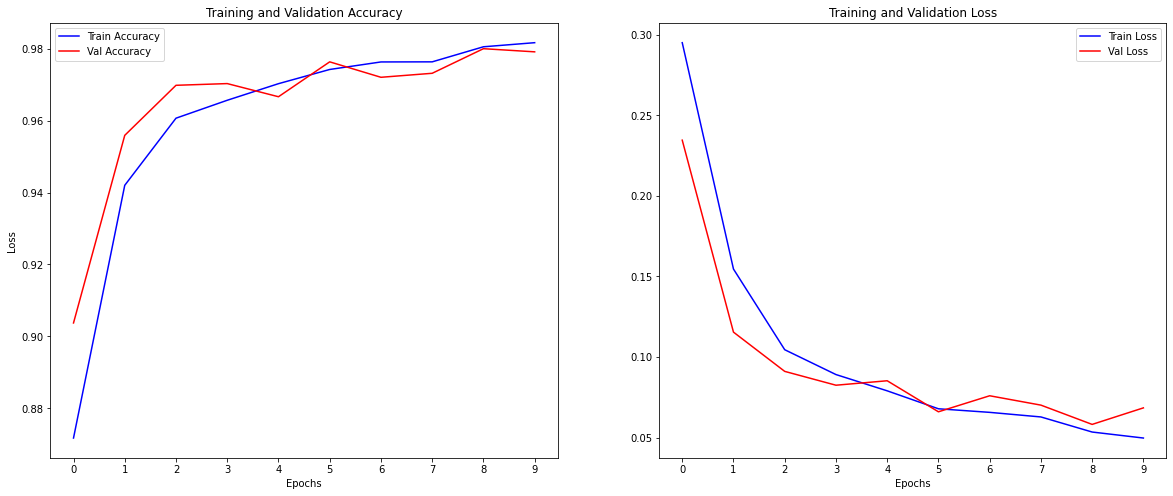

In [39]:
acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,8)
ax[0].plot(acc, color='b', label='Train Accuracy')
ax[0].plot(val_acc, color='r', label='Val Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].set_xticks([i for i in range(EPOCHS)])
ax[0].legend()

ax[1].plot(loss, color='b', label='Train Loss')
ax[1].plot(val_loss, color='r', label='Val Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel("Loss")
ax[1].set_xticks([i for i in range(EPOCHS)])
ax[1].legend();

In [40]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Validation Data is - " , model.evaluate(x_val,y_val)[1]*100 , "%")
print("Accuracy of the model on Test Data is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

1180/1180 [==============================] - 180s 152ms/step - loss: 0.0284 - acc: 0.9899
Accuracy of the model on Training Data is -  98.99061918258667 %
394/394 [==============================] - 61s 154ms/step - loss: 0.0684 - acc: 0.9791
Accuracy of the model on Validation Data is -  97.90971279144287 %
394/394 [==============================] - 61s 154ms/step - loss: 0.0726 - acc: 0.9755
Accuracy of the model on Test Data is -  97.55206108093262 %


In [41]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred, target_names = ['Fake','Real']))

              precision    recall  f1-score   support

        Fake       0.61      1.00      0.76      7687
        Real       0.00      0.00      0.00      4895

    accuracy                           0.61     12582
   macro avg       0.31      0.50      0.38     12582
weighted avg       0.37      0.61      0.46     12582



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [42]:
print(set(y_pred))
print(set(y_test))

{0}
{0, 1}


In [43]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[7687,    0],
       [4895,    0]])

Text(51.0, 0.5, 'Actual')

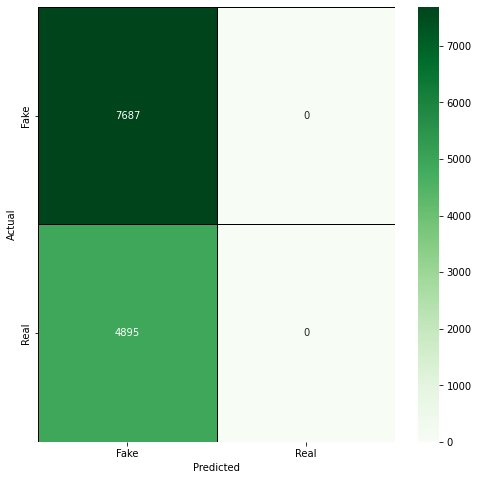

In [44]:
cm = pd.DataFrame(cm , index = ['Fake','Real'] , columns = ['Fake','Real'])
plt.figure(figsize = (8,8))
sns.heatmap(cm,cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [45]:
from sklearn.metrics import auc, roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)

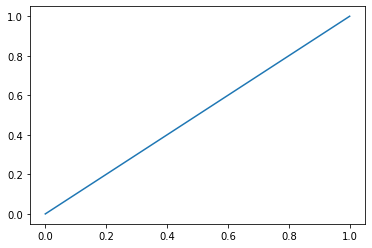

In [46]:
plt.plot(fpr,tpr)

### K Nearest Neighbours

In [47]:
# from sklearn.neighbors import KNeighborsClassifier

# knn = KNeighborsClassifier(20, verbose=1)
# knn.fit(x_train,y_train)

# knn_preds = knn.predict(x_test)
# #knn_preds = np.argmax(knn_preds, axis=1)

# print(classification_report(y_test, knn_pred, target_names = ['Fake','Real']))

In [48]:
# cm_knn = confusion_matrix(y_test,knn_preds)
# cm_knn = pd.DataFrame(cm_knn , index = ['Fake','Real'] , columns = ['Fake','Real'])
# plt.figure(figsize = (8,8))
# sns.heatmap(cm_knn,cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")

### Logistic Regression

In [49]:
from sklearn.linear_model import LogisticRegression

logR = LogisticRegression()
logR.fit(x_train,y_train)

log_preds = logR.predict(x_test)

print(classification_report(y_test, log_preds, target_names = ['Fake','Real']))

              precision    recall  f1-score   support

        Fake       0.65      0.87      0.74      7687
        Real       0.56      0.27      0.36      4895

    accuracy                           0.63     12582
   macro avg       0.60      0.57      0.55     12582
weighted avg       0.61      0.63      0.59     12582



Text(51.0, 0.5, 'Actual')

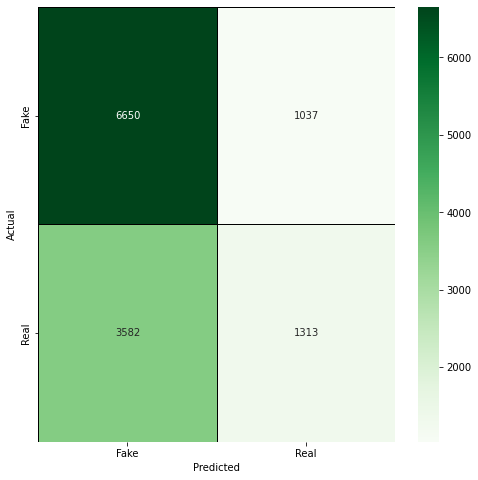

In [50]:
cm_log = confusion_matrix(y_test,log_preds)
cm_log = pd.DataFrame(cm_log , index = ['Fake','Real'] , columns = ['Fake','Real'])
plt.figure(figsize = (8,8))
sns.heatmap(cm_log,cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])
plt.xlabel("Predicted")
plt.ylabel("Actual")


### Multinomial Naive Bayes

In [51]:
from sklearn.naive_bayes import MultinomialNB 

bayes = MultinomialNB(alpha=0.1) 
bayes.fit(x_train, y_train)

bayes_preds = bayes.predict(x_test)

print(classification_report(y_test, bayes_preds, target_names = ['Fake','Real']))

              precision    recall  f1-score   support

        Fake       0.68      0.51      0.59      7687
        Real       0.45      0.62      0.52      4895

    accuracy                           0.56     12582
   macro avg       0.57      0.57      0.55     12582
weighted avg       0.59      0.56      0.56     12582



Text(51.0, 0.5, 'Actual')

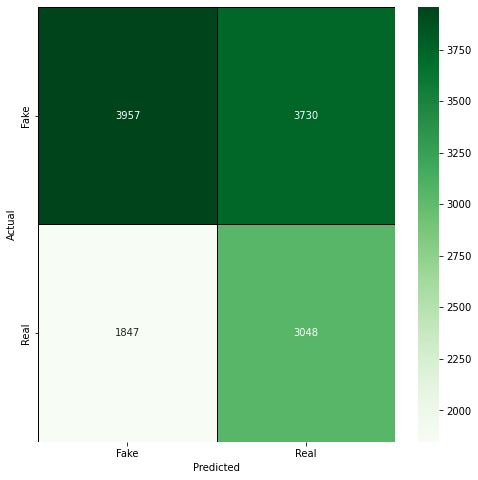

In [52]:
cm_bayes = confusion_matrix(y_test,bayes_preds)
cm_bayes = pd.DataFrame(cm_bayes , index = ['Fake','Real'] , columns = ['Fake','Real'])
plt.figure(figsize = (8,8))
sns.heatmap(cm_bayes,cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])
plt.xlabel("Predicted")
plt.ylabel("Actual")


### Support Vector Machine

In [53]:
# from sklearn.svm import SVC

# sv = SVC(kernel='rbf', verbose=1) 
# sv.fit(x_train, y_train)

# sv_preds = sv.predict(x_test)
# #ada_preds = np.argmax(ada_preds, axis=1)

# print(classification_report(y_test, sv_preds, target_names = ['Fake','Real']))

In [54]:
# cm_sv = confusion_matrix(y_test,sv_preds)
# cm_sv = pd.DataFrame(cm_sv , index = ['Fake','Real'] , columns = ['Fake','Real'])
# plt.figure(figsize = (8,8))
# sns.heatmap(cm_sv,cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")

### AdaBoost

In [55]:
# from sklearn.ensembles import AdaBoostClassifier

# ada = AdaBoostClassifier(verbose=1)
# ada.fit(x_train, y_train)

# ada_preds = ada.predict(x_test)
# #ada_preds = np.argmax(ada_preds, axis=1)

# print(classification_report(y_test, ada_pred, target_names = ['Fake','Real']))

In [56]:
# cm_ada = confusion_matrix(y_test,ada_preds)
# cm_ada = pd.DataFrame(cm_ada , index = ['Fake','Real'] , columns = ['Fake','Real'])
# plt.figure(figsize = (8,8))
# sns.heatmap(cm_ada,cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")

### ROC Curves

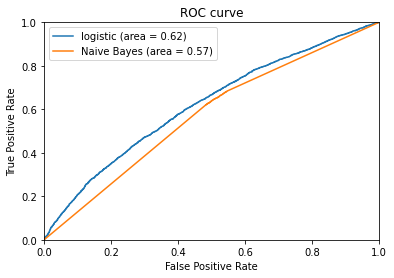

In [57]:
import sklearn
# We'll need class probabilities from each of the classifiers
y_log   = logR.predict_proba(x_test)
y_bayes = bayes.predict_proba(x_test)
#y_knn   = knn.predict_proba(x_test)

# Compute the points on the curve
# We pass the probability of the second class (KIA) as the y_score
curve_log    = sklearn.metrics.roc_curve(y_test, y_log[:, 1])
curve_bayes  = sklearn.metrics.roc_curve(y_test, y_bayes[:, 1])
#curve_knn    = sklearn.metrics.roc_curve(y_test, y_knn[:, 1])

# Compute Area Under the Curve
auc_log    = auc(curve_log[0], curve_log[1])
auc_bayes  = auc(curve_bayes[0], curve_bayes[1])
#auc_knn    = auc(curve_knn[0], curve_knn[1])

plt.plot(curve_log[0], curve_log[1], label='logistic (area = %0.2f)' % auc_log)
plt.plot(curve_bayes[0], curve_bayes[1], label='Naive Bayes (area = %0.2f)' % auc_bayes)
#plt.plot(curve_knn[0], curve_knn[1], label='knn (area = %0.2f)'% auc_knn)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve');

plt.legend();